# 🧠 Aide pour le Challenge CTF - Data Leakage
Dans ce challenge, tu vas entraîner un modèle de machine learning sur un jeu de données de startups.
Le but est de prédire si une startup va réussir (`Success = 1`) ou échouer (`Success = 0`)


## 🕵️ Étapes conseillées

**Explorer les données** : affiche quelques lignes


**Vérifier la corrélation** entre les colonnes


Est-ce qu’une information est trop prédictive, comme un identifiant ou un code qui encode le succès ?

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Load the dataset
df = pd.read_csv('D:\Documents 2\VScode projects\ROBAI2\challenges\data\startup.csv')

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Founding Year             200 non-null    int64  
 1   Team Size                 200 non-null    int64  
 2   Funding Amount (USD)      200 non-null    float64
 3   Number of AI Patents      200 non-null    int64  
 4   Website Visits per Month  200 non-null    int64  
 5   CEO Name                  200 non-null    object 
 6   Startup Code              200 non-null    object 
 7   Success                   200 non-null    int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 12.6+ KB
None
       Founding Year   Team Size  Funding Amount (USD)  Number of AI Patents  \
count     200.000000  200.000000          2.000000e+02              200.0000   
mean     2016.930000   50.135000          4.992184e+06                3.0400   
std         4.003152   29.210839      

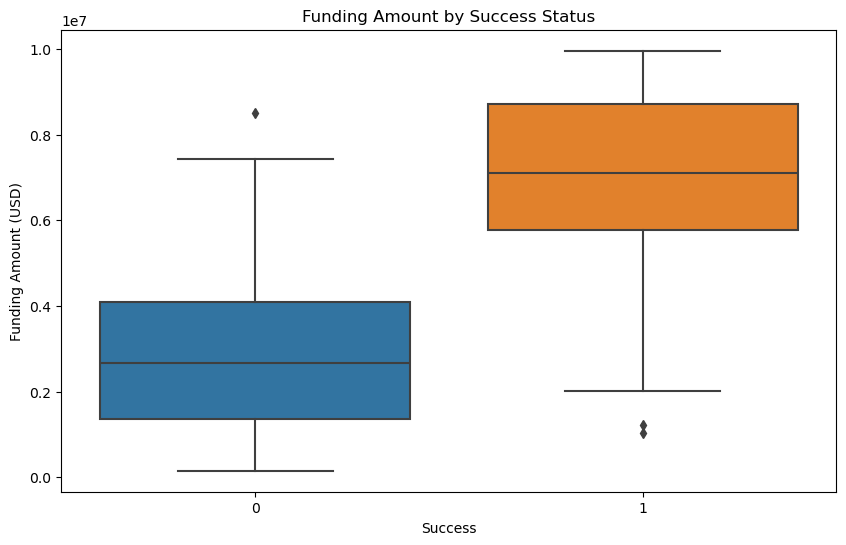

<Axes: xlabel='Funding Amount (USD)'>

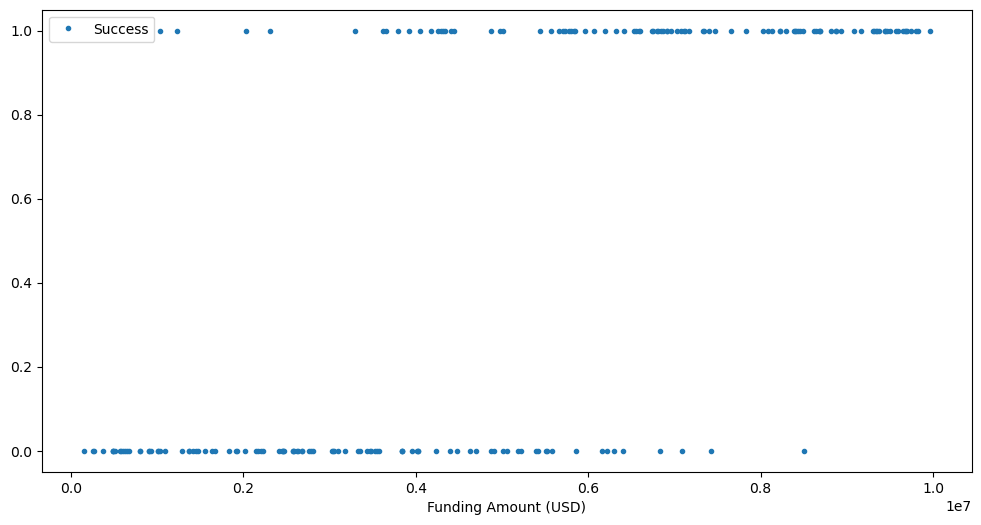

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Success', y='Funding Amount (USD)', data=df)
plt.title('Funding Amount by Success Status')
plt.show()

# Or check for a threshold
df.sort_values('Funding Amount (USD)').plot(
    x='Funding Amount (USD)', y='Success', 
    style='.', figsize=(12, 6))

In [29]:
print(df[['Funding Amount (USD)', 'Team Size', 'Website Visits per Month', 
         'Number of AI Patents', 'Founding Year', 'Success']].corr()['Success'])

Funding Amount (USD)        0.710880
Team Size                   0.328955
Website Visits per Month    0.149127
Number of AI Patents        0.193958
Founding Year              -0.080138
Success                     1.000000
Name: Success, dtype: float64


Missing values:
 Founding Year               0
Team Size                   0
Funding Amount (USD)        0
Number of AI Patents        0
Website Visits per Month    0
CEO Name                    0
Startup Code                0
Success                     0
dtype: int64
0       S-FAIL-2824
1       S-FAIL-1409
2    S-SUCCESS-5506
3       S-FAIL-5012
4    S-SUCCESS-4657
5    S-SUCCESS-3286
6       S-FAIL-2679
7       S-FAIL-9935
8    S-SUCCESS-2424
9    S-SUCCESS-7912
Name: Startup Code, dtype: object


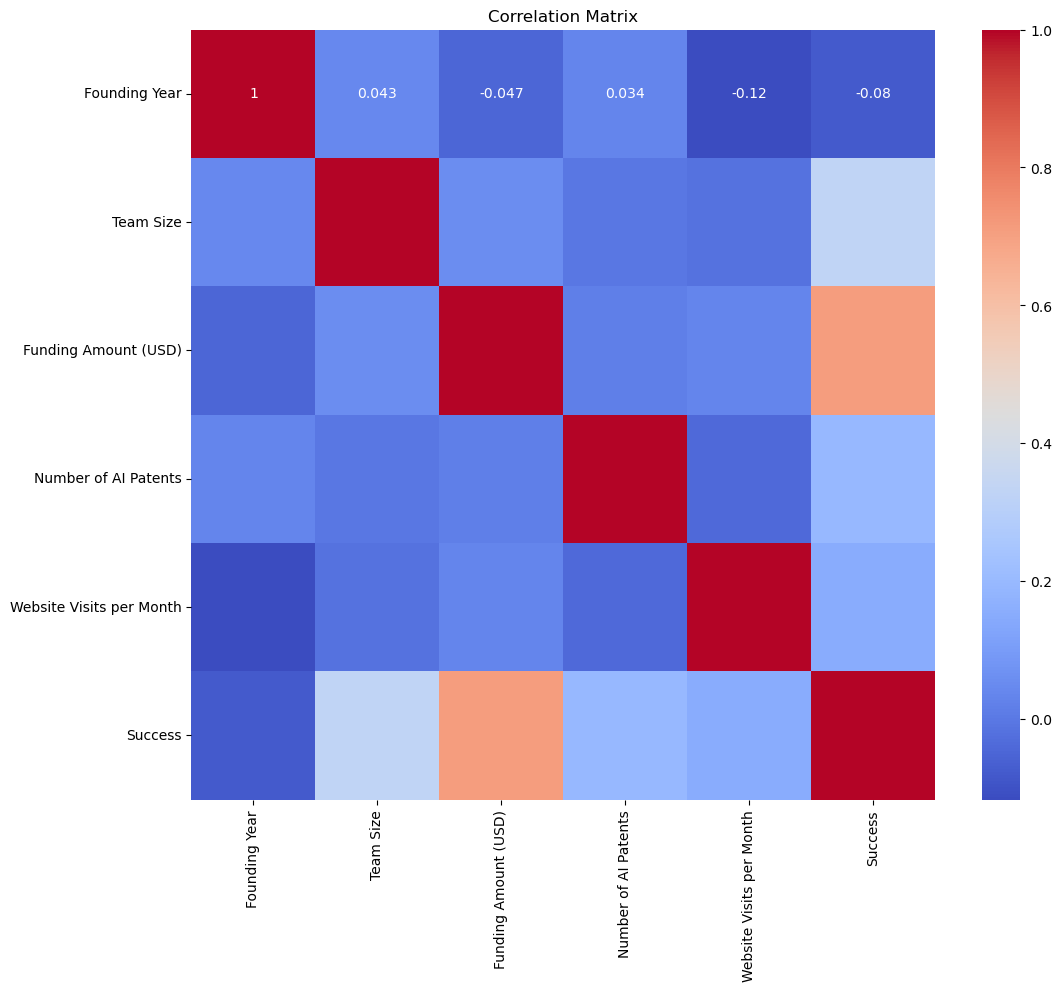

In [30]:
print("Missing values:\n", df.isnull().sum())

# Examine the Startup Code column
print(df['Startup Code'].head(10))

# Check correlation between columns
plt.figure(figsize=(12, 10))
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [31]:
# Check the relationship between CEO names and success
ceo_success_rate = df.groupby('CEO Name')['Success'].mean().sort_values(ascending=False)
print("CEO Success Rate:\n", ceo_success_rate)

# Remove biasing columns - Startup Code definitely needs to be removed
df_cleaned = df.drop(['Startup Code', 'CEO Name', 'Funding Amount (USD)'], axis=1)

CEO Success Rate:
 CEO Name
Alice      1.0
Bob        1.0
Charlie    1.0
Dana       1.0
Eve        0.0
Frank      0.0
Grace      0.0
Heidi      0.0
Name: Success, dtype: float64


In [32]:
# Split features and target
X = df_cleaned.drop('Success', axis=1)
y = df_cleaned['Success']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

In [33]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


Accuracy: 0.55

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.65      0.55        17
           1       0.65      0.48      0.55        23

    accuracy                           0.55        40
   macro avg       0.56      0.56      0.55        40
weighted avg       0.58      0.55      0.55        40


Feature Importances:
Team Size                   0.352419
Website Visits per Month    0.330148
Founding Year               0.159217
Number of AI Patents        0.158217
dtype: float64


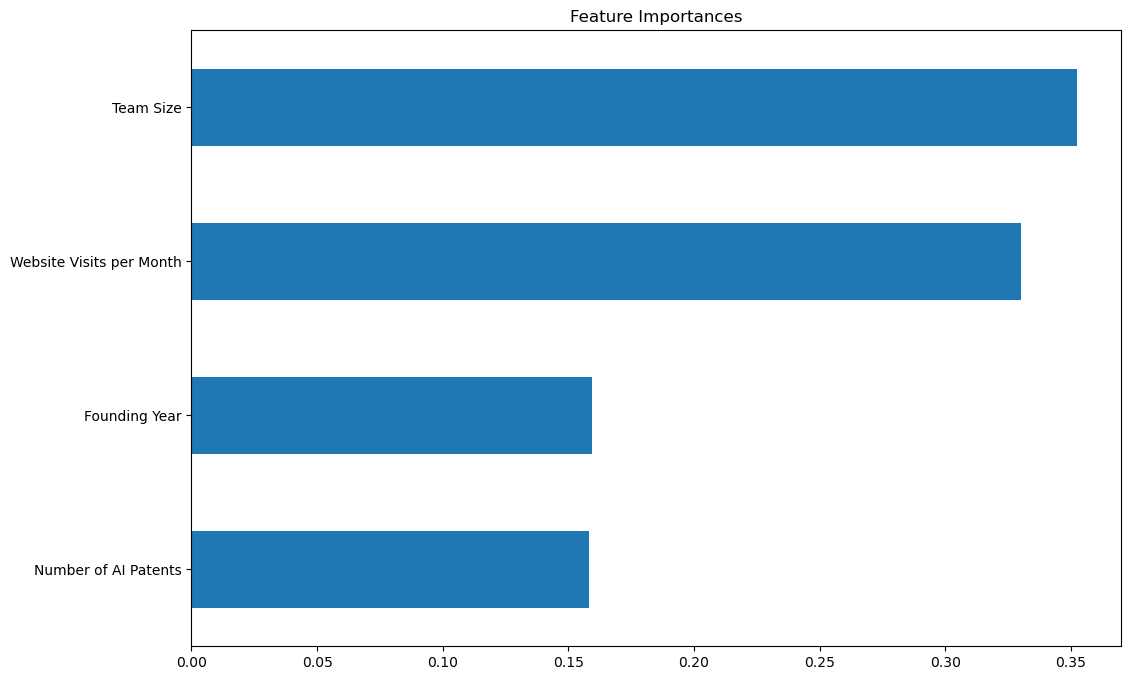

In [34]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Check feature importances
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
print("\nFeature Importances:")
print(feature_importances.sort_values(ascending=False))

# Visualize feature importances
plt.figure(figsize=(12, 8))
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importances')
plt.show()

In [45]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(RandomForestClassifier(), X, y, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Average score: {scores.mean()}")

Cross-validation scores: [0.625 0.625 0.7   0.7   0.65 ]
Average score: 0.6599999999999999


## 🧩 Objectif final

Supprime les colonnes qui biaisent l’apprentissage.

Tu dois entraîner un modèle **qui généralise bien**

In [ ]:
# THE FLAG
print("CTF{CODE_CEO_FUNDING_%66}")
print("FLAG{BIASED_FEATURES_REMOVED_%66}")

The flag is:  S-SUCCESS-5506
CTF{CODE_CEO_FUNDING_66}
FLAG{BIASED_FEATURES_REMOVED_%66}
